# Modelli di regressione

In questa parte del progetto, si mira a sviluppare modelli per la previsione della potenza media consumata in diverse zone del Trentino durante le fasce orarie 9-18,18-24 e 18-19. Al fine di prevedere tale potenza, vengono adottati due approcci distinti. Il primo approccio si basa sull'utilizzo dei dati relativi alla giornata precedente, mentre il secondo approccio sfrutta i dati relativi ai due giorni precedenti.
Successivamente si svliluppano ulteriori modelli per prevedere la potenza media della specifica zona del comune di Trento

## Predizione della potenza in base ai parametri del giorno precedente

In [1]:
import pandas as pd
import numpy as np
import geopandas as gp
from datetime import datetime
from datetime import date
import seaborn as sns
import ydata_profiling as yp
from ydata_profiling import ProfileReport 
%matplotlib inline

Cominciamo caricando i dataset contenenti le potenze medie delle fasce orarie 9-18 e 18-19 creati precedentemente

In [2]:
df_day_nov=pd.read_csv("reg/df_day_nov.csv")
del df_day_nov['Unnamed: 0']
df_day_dec=pd.read_csv("reg/df_day_dec.csv")
del df_day_dec['Unnamed: 0']
df_day_dec['DAY']=df_day_dec['DAY']+30
df_day=pd.concat([df_day_nov, df_day_dec], ignore_index=True)

df_night_nov=pd.read_csv("reg/df_night_nov.csv")
del df_night_nov['Unnamed: 0']
df_night_dec=pd.read_csv("reg/df_night_dec.csv")
del df_night_dec['Unnamed: 0']
df_night_dec['DAY']=df_night_dec['DAY']+30
df_night=pd.concat([df_night_nov, df_night_dec], ignore_index=True)


Controlliamo che non ci siano valori nulli

In [3]:
df_day.isnull().sum()
df_night.isnull().sum()

SQUAREID             0
DAY                  0
DAY_ID               0
LUN                  0
MAR                  0
MER                  0
GIO                  0
VEN                  0
SAB                  0
DOM                  0
SQUARE_UBICAZIONI    0
NR_LINES             0
DAWN                 0
SUNSET               0
DAYLENGHT            0
minTemperature       0
maxTemperature       0
POWER                0
dtype: int64

Procediamo all'inserimento dei valori del giorno successivo in una nuova colonna denominata 'POWER_NEXT'. Qualora la colonna successiva corrisponda a un diverso squareid, verrà inserito un valore NaN. Infine, effettuiamo la rimozione dei valori nulli per ottenere un dataset coerente.

In [4]:
df_day['POWER_NEXT']=np.where(df_day['SQUAREID'].shift(-1)==df_day['SQUAREID'], df_day['POWER'].shift(-1), np.NaN)
df_day.dropna(inplace=True)
df_night['POWER_NEXT']=np.where(df_night['SQUAREID'].shift(-1)==df_night['SQUAREID'], df_night['POWER'].shift(-1), np.NaN)
df_night.dropna(inplace=True)

In [5]:
report=ProfileReport(df_day,title='Dati originali')
report.to_file('dati_regressione.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Dal file di data profiling notiamo che l'ora del l'alba e del tramonto sono quasi totalmente correlate, perciò rimuoviamo queste colonne 
dal dataset X

Creiamo due nuovi dataset: 
  * **X** che contiene le caratteristiche (features) necessarie per predire la potenza media.
  * **Y** che conterrà i valori corrispondenti alla potenza media.
  
    Una volta creati X e Y, applichiamo la normalizzazione alle colonne presenti in X. 
    Questo passaggio è importante per garantire che le caratteristiche abbiano la stessa scala
    e non influenzino in modo sproporzionato i modelli che creeremo successivamente.
    Inoltre, al fine di evitare che i modelli memorizzino informazioni irrilevanti, rimuoviamo la colonna "DAY" da X.
    Infatti, il giorno potrebbe non avere un impatto significativo sulla predizione della potenza media e la sua 
    presenza potrebbe addirittura generare rumore nei modelli. Allo stesso modo, decidiamo di eliminare anche la
    colonna 'SQUAREID', poiché non fornisce informazioni rilevanti per la predizione della potenza media e potrebbe 
    introdurre un'eccessiva complessità nel modello senza apportare benefici significativi. L'eliminazione di queste 
    colonne ci permette di concentrarci sulle caratteristiche più pertinenti e ottimizzare l'accuratezza delle nostre
    previsioni.

In [6]:
from sklearn import datasets
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

scal = StandardScaler()

X_day=df_day.drop(columns=['SQUAREID','DAWN','SUNSET'])
X_night=df_night.drop(columns=['SQUAREID','DAWN','SUNSET'])


Dividiamo X e Y in tre classi: train, valid e test.

Per evitare che nei dati di train 'POWER_NEXT' coincida con 'POWER' assegniamo al dataset di train tutti i valori con giorno pari,i dati restanti vengono divisi equalmente tra test e valid

In [7]:
X_train_day=X_day[(X_day['DAY']%2==0)]
X_valid_day=X_day[(X_day['DAY']%4==1)]
X_test_day=X_day[(X_day['DAY']%4==3)]

X_train_night=X_night[(X_night['DAY']%2==0)]
X_valid_night=X_night[(X_night['DAY']%4==1)]
X_test_night=X_night[(X_night['DAY']%4==3)]

Y_train_day=X_train_day['POWER_NEXT']
Y_valid_day=X_valid_day['POWER_NEXT']
Y_test_day=X_test_day['POWER_NEXT']

Y_train_night=X_train_night['POWER_NEXT']
Y_valid_night=X_valid_night['POWER_NEXT']
Y_test_night=X_test_night['POWER_NEXT']

X_day.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_night.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_train_day.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_train_night.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_valid_day.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_valid_night.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_test_day.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_test_night.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)

scal.fit(X_day)
X_train_day=scal.transform(X_train_day)
X_valid_day=scal.transform(X_valid_day)
X_test_day=scal.transform(X_test_day)

X_train_night=scal.transform(X_train_night)
X_valid_night=scal.transform(X_valid_night)
X_test_night=scal.transform(X_test_night)




C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\2896352935.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_day.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\2896352935.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_night.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\2896352935.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

Creiamo una funzione print_errors() per stampare gli errori del modello

In [8]:
def print_errors(model,x_train, y_train, x_test, y_test):
    score_train = model.score(x_train,y_train)
    score_test = model.score(x_test,y_test)

    E_train = mean_squared_error(model.predict(x_train), y_train)
    E_test = mean_squared_error(model.predict(x_test), y_test)
    print(f"r^2_train {score_train} - r^2_valid {score_test}")
    print(f"Err_train {E_train} - Err_valid {E_test}")

Proviamo a utilizzare un modello lineare

In [9]:
linear_m_day = LinearRegression()
linear_m_night = LinearRegression()
linear_m_day.fit(X_train_day,Y_train_day)
linear_m_night.fit(X_train_night,Y_train_night)

LinearRegression()

In [10]:
print('Modello lineare giorno:')
print_errors(linear_m_day,X_train_day,Y_train_day,X_valid_day,Y_valid_day)
print('Modello lineare notte:')
print_errors(linear_m_night,X_train_night,Y_train_night,X_valid_night,Y_valid_night)

Modello lineare giorno:
r^2_train 0.9260544349667679 - r^2_valid 0.9298182203245487
Err_train 10.055922263431158 - Err_valid 9.356988812094468
Modello lineare notte:
r^2_train 0.9392951111404249 - r^2_valid 0.9519198797689672
Err_train 5.328373132853444 - Err_valid 4.230528870386946


I modelli lineari sembrano fittare propriamente i dati dell'insieme valid. L'errore minore sui dati considerati nella fascia notturna potrebbe essere dovuto al fatto che di sera, in molte zone la varianza sulla potenza diminuisce rispetto al resto della giornata.
Proviamo a utilizzare il modello RidgeCV
e trovare il valore di alpha ideale

In [11]:
from sklearn.linear_model import RidgeCV
r_cv_day = RidgeCV(alphas= np.logspace(-4,0,num=20), cv=10)
r_cv_night = RidgeCV(alphas= np.logspace(-4,0,num=20), cv=10)
r_cv_day.fit(X_train_day, Y_train_day)
r_cv_night.fit(X_train_night, Y_train_night)
print('RidgeCV giorno:')
print_errors(r_cv_day,X_train_day,Y_train_day,X_valid_day,Y_valid_day)
print('RidgeCV notte:')
print_errors(r_cv_night,X_train_night,Y_train_night,X_valid_night,Y_valid_night)

RidgeCV giorno:
r^2_train 0.92605464508729 - r^2_valid 0.9298293142524956
Err_train 10.055893688957005 - Err_valid 9.355509713670905
RidgeCV notte:
r^2_train 0.939295142084969 - r^2_valid 0.951922481883942
Err_train 5.328370416695308 - Err_valid 4.230299912504302


In [12]:
r_cv_day.alpha_

0.0001

In [13]:
r_cv_night.alpha_

1.0

Vediamo adesso quali sono le feature più significative per i due modelli considerati

Text(0.5, 1.0, 'Pesi r_cv giorno')

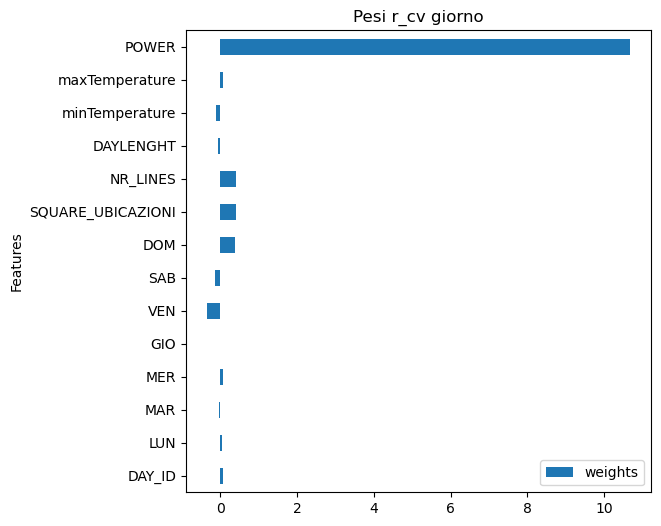

In [14]:
df_w = pd.DataFrame({'features': X_day.columns, 'weights': r_cv_day.coef_})
ax = df_w.plot.barh(y='weights', x='features', figsize=(6, 6))
ax.set_ylabel('Features')
ax.set_title('Pesi r_cv giorno')

Text(0.5, 1.0, 'Pesi r_cv notte')

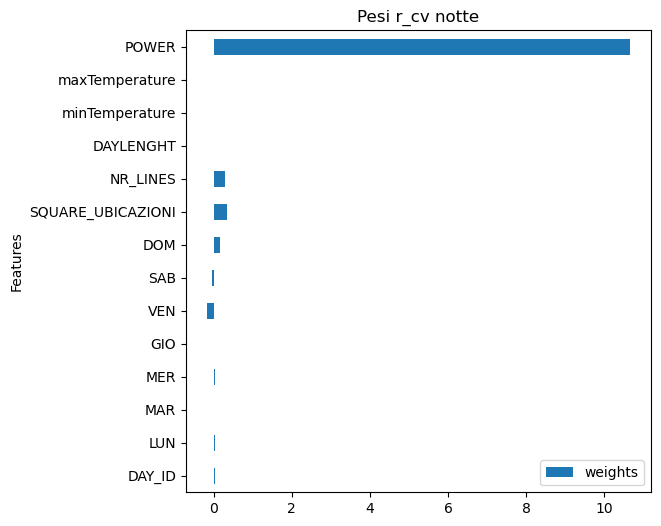

In [15]:
df_w = pd.DataFrame({'features': X_night.columns, 'weights': r_cv_night.coef_})
ax = df_w.plot.barh(y='weights', x='features', figsize=(6, 6))
ax.set_ylabel('Features')
ax.set_title('Pesi r_cv notte')


In entrambi i casi, osserviamo che le colonne relative ai giorni della settimana dal lunedì al giovedì,
insieme a 'DAY_ID' e 'DAYLENGHT', hanno un impatto trascurabile rispetto alle altre variabili. 
I giorni più importanti sono quelli del fine settimana dato che nel weekend, generalmente c'è una riduzione dei consumi in tutto il Trentino.
Di conseguenza, è possibile escluderle dal set di features senza compromettere in modo significativo le prestazioni del modello.

Proviamo ricreare il modello utilizzando solo le features più importanti

In [16]:
X_day=df_day[['DAY','VEN','SAB','DOM','SQUARE_UBICAZIONI','NR_LINES','POWER','POWER_NEXT']]
X_night=df_night[['DAY','VEN','SAB','DOM','SQUARE_UBICAZIONI','NR_LINES','POWER','POWER_NEXT']]

X_train_day=X_day[(X_day['DAY']%2==0)]
X_valid_day=X_day[(X_day['DAY']%4==1)]
X_test_day=X_day[(X_day['DAY']%4==3)]

X_train_night=X_night[(X_night['DAY']%2==0)]
X_valid_night=X_night[(X_night['DAY']%4==1)]
X_test_night=X_night[(X_night['DAY']%4==3)]

Y_train_day=X_train_day['POWER_NEXT']
Y_valid_day=X_valid_day['POWER_NEXT']
Y_test_day=X_test_day['POWER_NEXT']

Y_train_night=X_train_night['POWER_NEXT']
Y_valid_night=X_valid_night['POWER_NEXT']
Y_test_night=X_test_night['POWER_NEXT']

X_day.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_night.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_train_day.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_train_night.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_valid_day.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_valid_night.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_test_day.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_test_night.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)

scal.fit(X_day)
X_train_day=scal.transform(X_train_day)
X_valid_day=scal.transform(X_valid_day)
X_test_day=scal.transform(X_test_day)

X_train_night=scal.transform(X_train_night)
X_valid_night=scal.transform(X_valid_night)
X_test_night=scal.transform(X_test_night)



C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\3392577867.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_day.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\3392577867.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_night.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\3392577867.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [17]:
r_cv_day = RidgeCV(alphas= np.logspace(-4,0,num=30), cv=20)
r_cv_night = RidgeCV(alphas= np.logspace(-4,0,num=30), cv=20)
r_cv_day.fit(X_train_day, Y_train_day)
r_cv_night.fit(X_train_night, Y_train_night)
print('Modello lineare giorno:')
print_errors(r_cv_day,X_train_day,Y_train_day,X_valid_day,Y_valid_day)
print('Modello lineare notte:')
print_errors(r_cv_night,X_train_night,Y_train_night,X_valid_night,Y_valid_night)

Modello lineare giorno:
r^2_train 0.9259463870502638 - r^2_valid 0.9300717756000175
Err_train 10.070615794390074 - Err_valid 9.323183544020894
Modello lineare notte:
r^2_train 0.9392823139260932 - r^2_valid 0.9519080386761902
Err_train 5.329496408660408 - Err_valid 4.231570758065449


Notiamo che gli errori si sono migliorati in modo quasi impercettibile, con una riduzione di circa 0,01 rispetto alla configurazione precedente. Sebbene il miglioramento sia minimo, è comunque un segnale positivo che indica che la selezione delle feature più importanti ha contribuito a una leggera ottimizzazione delle prestazioni del modello. 

In [18]:
r_cv_day.alpha_

0.0001

In [19]:
r_cv_night.alpha_

1.0

Cerchiamo adesso il modello migliore considerando anche modelli polinomiali di grado 2 e 3. Per farlo utilizziamo una grid search

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
param_grid = {'model': [Ridge()],
              'model__alpha': [0.01,0.1,1.0], 
              'polynomialfeatures__degree': [1, 2, 3]}  # Gradi del polinomio

# Creo una pipeline con le features polinomiali
pipeline = Pipeline([
    ('polynomialfeatures', PolynomialFeatures()),
    ('model', Ridge())
])

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5)

grid_search.fit(X_train_day, Y_train_day)
best_model_day = grid_search.best_estimator_
grid_search.fit(X_train_night, Y_train_night)
best_model_night = grid_search.best_estimator_
print('Modello migliore giorno:')
print_errors(best_model_day,X_train_day,Y_train_day,X_valid_day,Y_valid_day)
print('Modello migliore notte:')
print_errors(best_model_night,X_train_night,Y_train_night,X_valid_night,Y_valid_night)

Modello migliore giorno:
r^2_train 0.9492852654318465 - r^2_valid 0.9426422590920072
Err_train 6.896741247412238 - Err_valid 7.647223288508771
Modello migliore notte:
r^2_train 0.9469280183865213 - r^2_valid 0.9520661183687347
Err_train 4.658394509060161 - Err_valid 4.217661460419819


In [21]:
best_model_day.get_params()

{'memory': None,
 'steps': [('polynomialfeatures', PolynomialFeatures()), ('model', Ridge())],
 'verbose': False,
 'polynomialfeatures': PolynomialFeatures(),
 'model': Ridge(),
 'polynomialfeatures__degree': 2,
 'polynomialfeatures__include_bias': True,
 'polynomialfeatures__interaction_only': False,
 'polynomialfeatures__order': 'C',
 'model__alpha': 1.0,
 'model__copy_X': True,
 'model__fit_intercept': True,
 'model__max_iter': None,
 'model__positive': False,
 'model__random_state': None,
 'model__solver': 'auto',
 'model__tol': 0.0001}

Notiamo come utilizzando un modello più complesso, gli errori e r2 migliorano

Uniamo i dataset train e valid e rifacciamo il train, confrontando infine le nostre stime di E_out e E_in

In [22]:
X_final_day=np.concatenate([X_train_day, X_valid_day])
X_final_night=np.concatenate([X_train_night, X_valid_night])
Y_final_day=np.concatenate([Y_train_day, Y_valid_day])
Y_final_night=np.concatenate([Y_train_night, Y_valid_night])

In [23]:
best_model_day.fit(X_final_day, Y_final_day)
best_model_night.fit(X_final_night, Y_final_night)
print('Modello migliore giorno:')
print_errors(best_model_day,X_final_day,Y_final_day,X_test_day,Y_test_day)
print('Modello migliore notte:')
print_errors(best_model_night,X_final_night,Y_final_night,X_test_night,Y_test_night)

Modello migliore giorno:
r^2_train 0.9475381844684766 - r^2_valid 0.9346730207274827
Err_train 7.086737745753845 - Err_valid 8.518407615054333
Modello migliore notte:
r^2_train 0.9491209561756493 - r^2_valid 0.9394892281172873
Err_train 4.469617525168842 - Err_valid 5.304075488526188


Visualizziamo i dati previsti dal modello

In [24]:
df_day['PRED']=best_model_day.predict(scal.transform(X_day))
df_night['PRED']=best_model_night.predict(scal.transform(X_night))

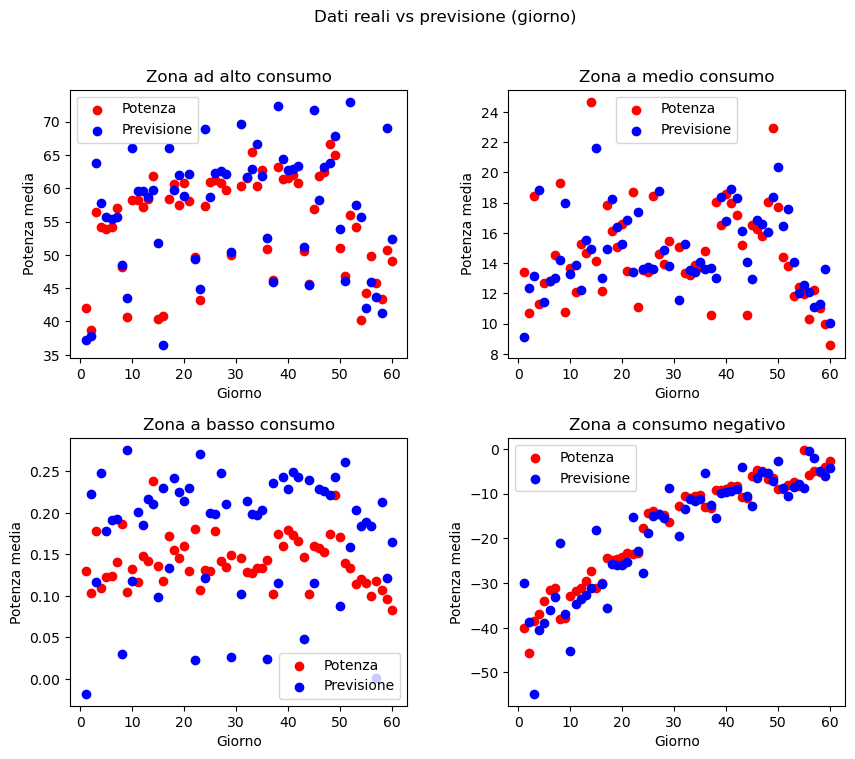

In [25]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Primo subplot
df_graph= df_day[(df_day["SQUAREID"] == 5318)]
axs[0, 0].scatter(df_graph['DAY'], df_graph['POWER_NEXT'], color='r', label='Potenza')
axs[0, 0].scatter(df_graph['DAY'], df_graph['PRED'], color='b', label='Previsione')
axs[0, 0].set_xlabel('Giorno')
axs[0, 0].set_ylabel('Potenza media')
axs[0, 0].set_title('Zona ad alto consumo')
axs[0, 0].legend()

# Secondo subplot
df_graph= df_day[(df_day["SQUAREID"] == 859)]
axs[0, 1].scatter(df_graph['DAY'], df_graph['POWER_NEXT'], color='r', label='Potenza')
axs[0, 1].scatter(df_graph['DAY'], df_graph['PRED'], color='b', label='Previsione')
axs[0, 1].set_xlabel('Giorno')
axs[0, 1].set_ylabel('Potenza media')
axs[0, 1].set_title('Zona a medio consumo')
axs[0, 1].legend()
# Terzo subplot
df_graph= df_day[(df_day["SQUAREID"] == 155)]
axs[1, 0].scatter(df_graph['DAY'], df_graph['POWER_NEXT'], color='r', label='Potenza')
axs[1, 0].scatter(df_graph['DAY'], df_graph['PRED'], color='b', label='Previsione')
axs[1, 0].set_xlabel('Giorno')
axs[1, 0].set_ylabel('Potenza media')
axs[1, 0].set_title('Zona a basso consumo')
axs[1, 0].legend()
# Quarto subplot
df_graph= df_day[(df_day["SQUAREID"] == 8212)]
axs[1, 1].scatter(df_graph['DAY'], df_graph['POWER_NEXT'], color='r', label='Potenza')
axs[1, 1].scatter(df_graph['DAY'], df_graph['PRED'], color='b', label='Previsione')
axs[1, 1].set_xlabel('Giorno')
axs[1, 1].set_ylabel('Potenza media')
axs[1, 1].set_title('Zona a consumo negativo')
axs[1, 1].legend()

plt.suptitle('Dati reali vs previsione (giorno)')
plt.subplots_adjust(hspace=0.3,wspace=0.3)
plt.show()

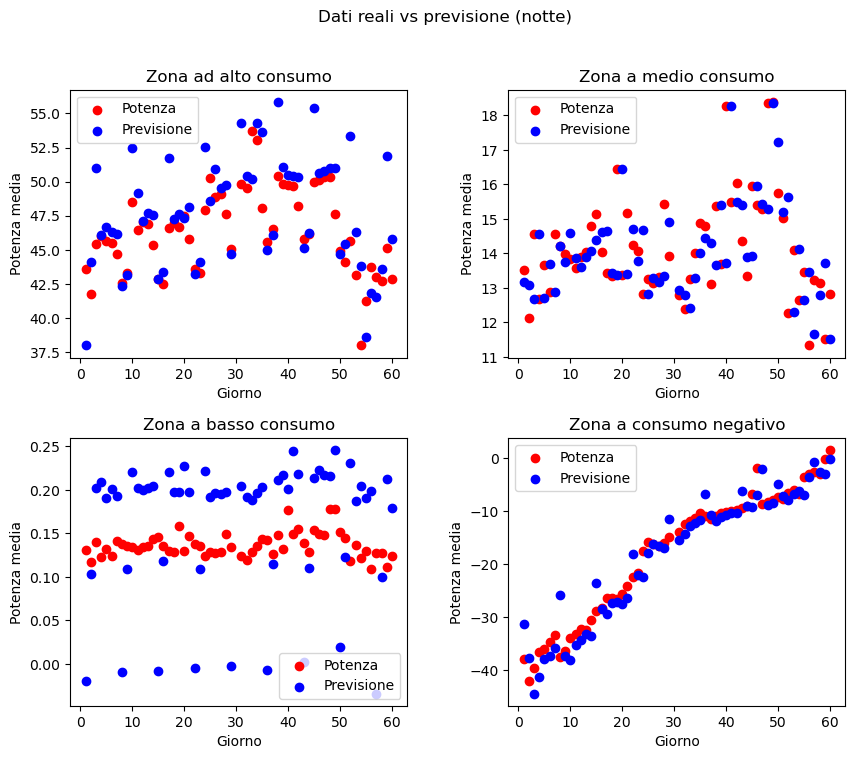

In [26]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Primo subplot
df_graph= df_night[(df_night["SQUAREID"] == 5318)]
axs[0, 0].scatter(df_graph['DAY'], df_graph['POWER_NEXT'], color='r', label='Potenza')
axs[0, 0].scatter(df_graph['DAY'], df_graph['PRED'], color='b', label='Previsione')
axs[0, 0].set_xlabel('Giorno')
axs[0, 0].set_ylabel('Potenza media')
axs[0, 0].set_title('Zona ad alto consumo')
axs[0, 0].legend()

# Secondo subplot
df_graph= df_night[(df_night["SQUAREID"] == 859)]
axs[0, 1].scatter(df_graph['DAY'], df_graph['POWER_NEXT'], color='r', label='Potenza')
axs[0, 1].scatter(df_graph['DAY'], df_graph['PRED'], color='b', label='Previsione')
axs[0, 1].set_xlabel('Giorno')
axs[0, 1].set_ylabel('Potenza media')
axs[0, 1].set_title('Zona a medio consumo')
axs[0, 1].legend()
# Terzo subplot
df_graph= df_night[(df_night["SQUAREID"] == 155)]
axs[1, 0].scatter(df_graph['DAY'], df_graph['POWER_NEXT'], color='r', label='Potenza')
axs[1, 0].scatter(df_graph['DAY'], df_graph['PRED'], color='b', label='Previsione')
axs[1, 0].set_xlabel('Giorno')
axs[1, 0].set_ylabel('Potenza media')
axs[1, 0].set_title('Zona a basso consumo')
axs[1, 0].legend()
# Quarto subplot
df_graph= df_night[(df_night["SQUAREID"] == 8212)]
axs[1, 1].scatter(df_graph['DAY'], df_graph['POWER_NEXT'], color='r', label='Potenza')
axs[1, 1].scatter(df_graph['DAY'], df_graph['PRED'], color='b', label='Previsione')
axs[1, 1].set_xlabel('Giorno')
axs[1, 1].set_ylabel('Potenza media')
axs[1, 1].set_title('Zona a consumo negativo')
axs[1, 1].legend()

plt.suptitle('Dati reali vs previsione (notte)')
plt.subplots_adjust(hspace=0.3,wspace=0.3)
plt.show()

Notiamo che il modello segue abbastanza bene l'andamento dei dati nelle zone ad alta, media e negativa potenza, tuttavia, è evidente la presenza di un bias. D'altra parte, nelle zone a bassa potenza si osserva una varianza molto elevata. I nostri modelli presentano errori medi di circa 7 kW durante il giorno e 4 kW durante la notte. Tali errori risultano significativi considerando che si tratta di zone a consumo energetico relativamente basso. Per affrontare questa problematica, possiamo adottare una strategia: anziché prevedere direttamente la potenza, possiamo invece prevedere il logaritmo della potenza. In questo modo, si riducono gli ordini di grandezza tra le diverse zone, consentendo una migliore gestione delle previsioni. Tale approccio potrebbe ridurre la varianza sulle zone a basso consumo e potrebbe contribuire a una maggiore precisione complessiva del modello.

## Predizione della potenza in base al logaritmo

Applichiamo una trasformazione logaritmica in base 10 alle colonne relative alla potenza, selezionando solo i dati che presentano valori positivi. 

In [27]:
df_day=df_day[(df_day['POWER']>0)&(df_day['POWER_NEXT']>0)]
df_day['LOG_POW']=np.log10(df_day['POWER'])
df_day['LOG_POW_NEXT']=np.log10(df_day['POWER_NEXT'])
df_day.dropna(how='all',inplace=True)

df_night=df_night[(df_night['POWER']>0)&(df_night['POWER_NEXT']>0)]
df_night['LOG_POW']=np.log10(df_night['POWER'])
df_night['LOG_POW_NEXT']=np.log10(df_night['POWER_NEXT'])
df_night.dropna(how='all',inplace=True)
df_day.drop(['POWER'], axis=1,inplace=True)
df_night.drop(['POWER'], axis=1,inplace=True)
df_day

C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\2827085720.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day['LOG_POW']=np.log10(df_day['POWER'])
C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\2827085720.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day['LOG_POW_NEXT']=np.log10(df_day['POWER_NEXT'])
C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\2827085720.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

,SQUAREID,DAY,DAY_ID,LUN,MAR,MER,GIO,VEN,SAB,DOM,...,NR_LINES,DAWN,SUNSET,DAYLENGHT,minTemperature,maxTemperature,POWER_NEXT,PRED,LOG_POW,LOG_POW_NEXT
0,155,1,4,0,0,0,0,1,0,0,...,1,457,991,533,9.2,18.9,0.129407,-0.017791,-1.133527,-0.888043
1,155,2,5,0,0,0,0,0,1,0,...,1,459,990,531,11.8,15.9,0.103237,0.223195,-0.888043,-0.986165
2,155,3,6,0,0,0,0,0,0,1,...,1,460,990,530,11.0,19.2,0.178362,0.117243,-0.986165,-0.748697
3,155,4,0,1,0,0,0,0,0,0,...,1,461,989,528,8.6,11.5,0.109082,0.247916,-0.748697,-0.962245
4,155,5,1,0,1,0,0,0,0,0,...,1,462,989,527,7.4,16.6,0.122315,0.178136,-0.962245,-0.912519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120947,11099,56,3,0,0,0,1,0,0,0,...,1,477,994,517,0.1,0.9,0.300136,0.402466,-0.481374,-0.522681
120948,11099,57,4,0,0,0,0,1,0,0,...,1,477,995,517,-3.4,2.0,0.319235,0.135264,-0.522681,-0.495890
120949,11099,58,5,0,0,0,0,0,1,0,...,1,477,996,518,-4.1,2.8,0.332945,0.399755,-0.495890,-0.477627
120950,11099,59,6,0,0,0,0,0,0,1,...,1,478,997,519,-2.6,2.2,0.326883,0.383867,-0.477627,-0.485607


In [28]:
df_day.isnull().sum()

SQUAREID             0
DAY                  0
DAY_ID               0
LUN                  0
MAR                  0
MER                  0
GIO                  0
VEN                  0
SAB                  0
DOM                  0
SQUARE_UBICAZIONI    0
NR_LINES             0
DAWN                 0
SUNSET               0
DAYLENGHT            0
minTemperature       0
maxTemperature       0
POWER_NEXT           0
PRED                 0
LOG_POW              0
LOG_POW_NEXT         0
dtype: int64

In [29]:
scal_log = StandardScaler()

X_day=df_day.drop(columns=['SQUAREID','DAWN','SUNSET'])
X_night=df_night.drop(columns=['SQUAREID','DAWN','SUNSET'])

X_train_day=X_day[(X_day['DAY']%2==0)]
X_valid_day=X_day[(X_day['DAY']%4==1)]
X_test_day=X_day[(X_day['DAY']%4==3)]

X_train_night=X_night[(X_night['DAY']%2==0)]
X_valid_night=X_night[(X_night['DAY']%4==1)]
X_test_night=X_night[(X_night['DAY']%4==3)]

Y_train_day=X_train_day['LOG_POW_NEXT']
Y_valid_day=X_valid_day['LOG_POW_NEXT']
Y_test_day=X_test_day['LOG_POW_NEXT']

Y_train_night=X_train_night['LOG_POW_NEXT']
Y_valid_night=X_valid_night['LOG_POW_NEXT']
Y_test_night=X_test_night['LOG_POW_NEXT']

X_day.drop(['LOG_POW_NEXT','POWER_NEXT','DAY','PRED'], axis=1,inplace=True)
X_night.drop(['LOG_POW_NEXT','POWER_NEXT','DAY','PRED'], axis=1,inplace=True)
X_train_day.drop(['LOG_POW_NEXT','POWER_NEXT','DAY','PRED'], axis=1,inplace=True)
X_train_night.drop(['LOG_POW_NEXT','POWER_NEXT','DAY','PRED'], axis=1,inplace=True)
X_valid_day.drop(['LOG_POW_NEXT','POWER_NEXT','DAY','PRED'], axis=1,inplace=True)
X_valid_night.drop(['LOG_POW_NEXT','POWER_NEXT','DAY','PRED'], axis=1,inplace=True)
X_test_day.drop(['LOG_POW_NEXT','POWER_NEXT','DAY','PRED'], axis=1,inplace=True)
X_test_night.drop(['LOG_POW_NEXT','POWER_NEXT','DAY','PRED'], axis=1,inplace=True)

scal_log.fit(X_day)
X_train_day=scal_log.transform(X_train_day)
X_valid_day=scal_log.transform(X_valid_day)
X_test_day=scal_log.transform(X_test_day)

X_train_night=scal_log.transform(X_train_night)
X_valid_night=scal_log.transform(X_valid_night)
X_test_night=scal_log.transform(X_test_night)

C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\443329163.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_day.drop(['LOG_POW_NEXT','POWER_NEXT','DAY','PRED'], axis=1,inplace=True)
C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\443329163.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_night.drop(['LOG_POW_NEXT','POWER_NEXT','DAY','PRED'], axis=1,inplace=True)
C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\443329163.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

In [30]:
from sklearn.linear_model import RidgeCV
r_cv_day_log = RidgeCV(alphas= np.logspace(-4,0,num=20), cv=10)
r_cv_night_log = RidgeCV(alphas= np.logspace(-4,0,num=20), cv=10)
r_cv_day_log.fit(X_train_day, Y_train_day)
r_cv_night_log.fit(X_train_night, Y_train_night)
print('RidgeCV giorno:')
print_errors(r_cv_day_log,X_train_day,Y_train_day,X_valid_day,Y_valid_day)
print('RidgeCV notte:')
print_errors(r_cv_night_log,X_train_night,Y_train_night,X_valid_night,Y_valid_night)

RidgeCV giorno:
r^2_train 0.9594280184716732 - r^2_valid 0.9706102237782608
Err_train 0.032212394389692756 - Err_valid 0.02281223019312038
RidgeCV notte:
r^2_train 0.9807797197949957 - r^2_valid 0.9771008565565521
Err_train 0.014158365455222576 - Err_valid 0.01682222375842677


I modelli mostrano un miglior coefficiente r2 rispetto alla fase precedente. Tuttavia, è importante considerare che l'errore calcolato si riferisce al logaritmo della potenza, pertanto è necessario propagarlo sulla base del valore di potenza corrispondente ad ogni zona. Questo significa che anche un errore piccolo nel logaritmo può tradursi in un errore significativo quando si valutano i valori reali di potenza. 


Vediamo adesso quali sono le feature più significative per i due modelli considerati

Text(0.5, 1.0, 'Pesi r_cv giorno')

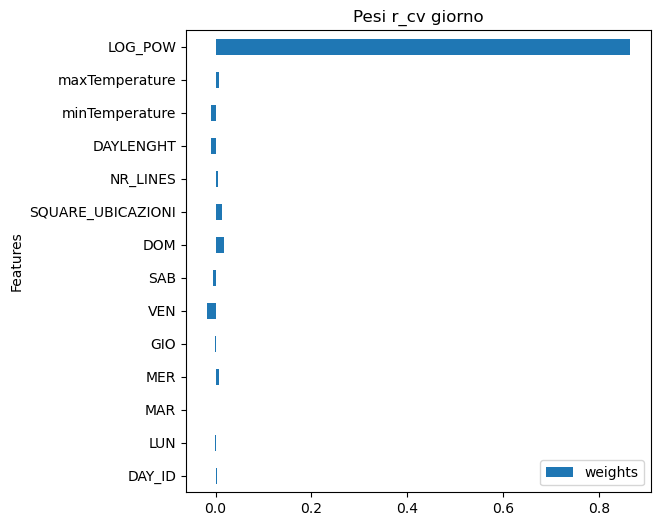

In [31]:
df_w = pd.DataFrame({'features': X_day.columns, 'weights': r_cv_day_log.coef_})
ax = df_w.plot.barh(y='weights', x='features', figsize=(6, 6))
ax.set_ylabel('Features')
ax.set_title('Pesi r_cv giorno')

Nonostante l'applicazione del logaritmo le feature più importanti rimangono le stesse

Text(0.5, 1.0, 'Pesi r_cv notte')

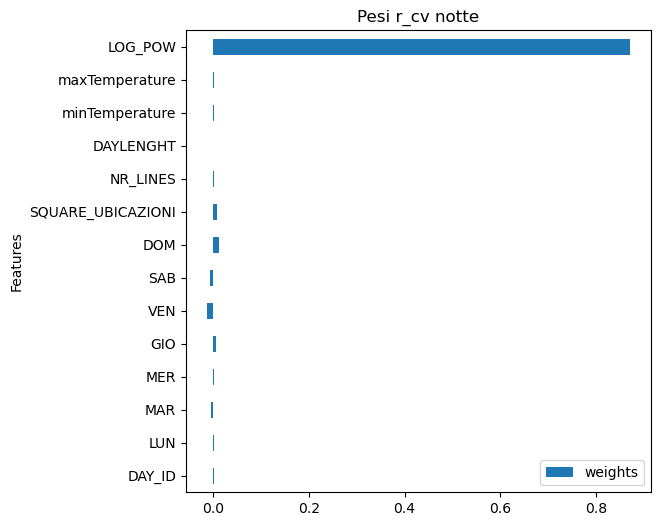

In [32]:
df_w = pd.DataFrame({'features': X_night.columns, 'weights': r_cv_night_log.coef_})
ax = df_w.plot.barh(y='weights', x='features', figsize=(6, 6))
ax.set_ylabel('Features')
ax.set_title('Pesi r_cv notte')

Con lo stesso procedimento di prima, cerchiamo il modello migliore tramite una grid search

In [33]:
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5)

grid_search.fit(X_train_day, Y_train_day)
best_model_day_log = grid_search.best_estimator_
grid_search.fit(X_train_night, Y_train_night)
best_model_night_log = grid_search.best_estimator_
print('Modello migliore giorno:')
print_errors(best_model_day_log,X_train_day,Y_train_day,X_valid_day,Y_valid_day)
print('Modello migliore notte:')
print_errors(best_model_night_log,X_train_night,Y_train_night,X_valid_night,Y_valid_night)

Modello migliore giorno:
r^2_train 0.9617732313169605 - r^2_valid 0.9691233442681585
Err_train 0.03035039706408961 - Err_valid 0.023966340295830175
Modello migliore notte:
r^2_train 0.9844770022618557 - r^2_valid 0.9146327754391705
Err_train 0.011434811178247874 - Err_valid 0.06271267555245781


In [34]:
best_model_day_log.get_params()

{'memory': None,
 'steps': [('polynomialfeatures', PolynomialFeatures()), ('model', Ridge())],
 'verbose': False,
 'polynomialfeatures': PolynomialFeatures(),
 'model': Ridge(),
 'polynomialfeatures__degree': 2,
 'polynomialfeatures__include_bias': True,
 'polynomialfeatures__interaction_only': False,
 'polynomialfeatures__order': 'C',
 'model__alpha': 1.0,
 'model__copy_X': True,
 'model__fit_intercept': True,
 'model__max_iter': None,
 'model__positive': False,
 'model__random_state': None,
 'model__solver': 'auto',
 'model__tol': 0.0001}

Anche in questo caso il modello migliore è polinomiale di grado 2

Uniamo i dataset train e valid 

In [35]:
X_final_day=np.concatenate([X_train_day, X_valid_day])
X_final_night=np.concatenate([X_train_night, X_valid_night])
Y_final_day=np.concatenate([Y_train_day, Y_valid_day])
Y_final_night=np.concatenate([Y_train_night, Y_valid_night])

In [36]:
best_model_day_log.fit(X_final_day, Y_final_day)
best_model_night_log.fit(X_final_night, Y_final_night)
print('Modello migliore giorno:')
print_errors(best_model_day_log,X_final_day,Y_final_day,X_test_day,Y_test_day)
print('Modello migliore notte:')
print_errors(best_model_night_log,X_final_night,Y_final_night,X_test_night,Y_test_night)

Modello migliore giorno:
r^2_train 0.9657869426237402 - r^2_valid 0.9462803768210097
Err_train 0.02695724062867892 - Err_valid 0.0418781280324751
Modello migliore notte:
r^2_train 0.9840458314289966 - r^2_valid 0.6985034705530009
Err_train 0.011741469658832883 - Err_valid 0.22327799610026397


Notiamo che nell'insieme test il modello notturno da dei problemi,in questo caso l'errore e r2 peggiorano notevolmente. Proviamo a calcolare l'errore utilizzando sempre il modello della fascia giornaliera

In [37]:
print('Modello migliore giorno:')
print_errors(best_model_day_log,X_final_night,Y_final_night,X_test_night,Y_test_night)

Modello migliore giorno:
r^2_train 0.9792109799718504 - r^2_valid 0.9751448085048369
Err_train 0.015299678376285136 - Err_valid 0.018406902924910533


Il modello della fascia oraria 9-18 risulta migliore del modello della fascia oraria notturna. Perciò possiamo usare solo questo modello scartando l'altro

Visualizziamo i dati previsti dal modello

In [38]:
df_day['PRED']=10**best_model_day_log.predict(scal_log.transform(X_day))
df_night['PRED']=10**best_model_day_log.predict(scal_log.transform(X_night))

C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\2936547946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day['PRED']=10**best_model_day_log.predict(scal_log.transform(X_day))


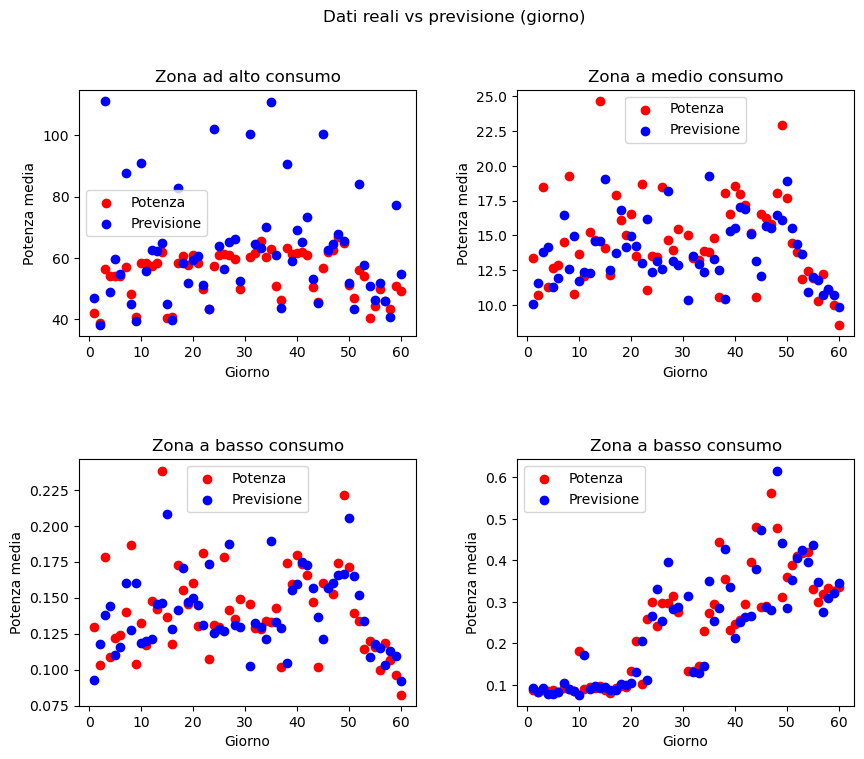

In [39]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Primo subplot
df_graph= df_day[(df_day["SQUAREID"] == 5318)]
axs[0, 0].scatter(df_graph['DAY'], df_graph['POWER_NEXT'], color='r', label='Potenza')
axs[0, 0].scatter(df_graph['DAY'], df_graph['PRED'], color='b', label='Previsione')
axs[0, 0].set_xlabel('Giorno')
axs[0, 0].set_ylabel('Potenza media')
axs[0, 0].set_title('Zona ad alto consumo')
axs[0, 0].legend()

# Secondo subplot
df_graph= df_day[(df_day["SQUAREID"] == 859)]
axs[0, 1].scatter(df_graph['DAY'], df_graph['POWER_NEXT'], color='r', label='Potenza')
axs[0, 1].scatter(df_graph['DAY'], df_graph['PRED'], color='b', label='Previsione')
axs[0, 1].set_xlabel('Giorno')
axs[0, 1].set_ylabel('Potenza media')
axs[0, 1].set_title('Zona a medio consumo')
axs[0, 1].legend()
# Terzo subplot
df_graph= df_day[(df_day["SQUAREID"] == 155)]
axs[1, 0].scatter(df_graph['DAY'], df_graph['POWER_NEXT'], color='r', label='Potenza')
axs[1, 0].scatter(df_graph['DAY'], df_graph['PRED'], color='b', label='Previsione')
axs[1, 0].set_xlabel('Giorno')
axs[1, 0].set_ylabel('Potenza media')
axs[1, 0].set_title('Zona a basso consumo')
axs[1, 0].legend()
# Quarto subplot
df_graph= df_day[(df_day["SQUAREID"] == 11099)]
axs[1, 1].scatter(df_graph['DAY'], df_graph['POWER_NEXT'], color='r', label='Potenza')
axs[1, 1].scatter(df_graph['DAY'], df_graph['PRED'], color='b', label='Previsione')
axs[1, 1].set_xlabel('Giorno')
axs[1, 1].set_ylabel('Potenza media')
axs[1, 1].set_title('Zona a basso consumo')
axs[1, 1].legend()
plt.suptitle('Dati reali vs previsione (giorno)')
plt.subplots_adjust(hspace=0.3,wspace=0.3)
plt.subplots_adjust(hspace=0.5)
plt.show()

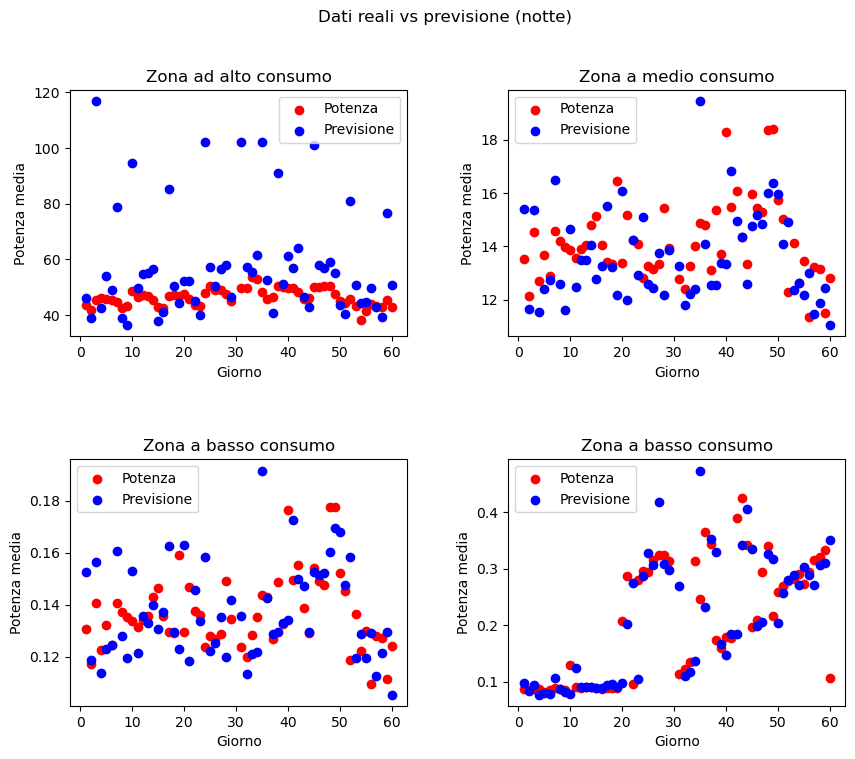

In [40]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Primo subplot
df_graph= df_night[(df_night["SQUAREID"] == 5318)]
axs[0, 0].scatter(df_graph['DAY'], df_graph['POWER_NEXT'], color='r', label='Potenza')
axs[0, 0].scatter(df_graph['DAY'], df_graph['PRED'], color='b', label='Previsione')
axs[0, 0].set_xlabel('Giorno')
axs[0, 0].set_ylabel('Potenza media')
axs[0, 0].set_title('Zona ad alto consumo')
axs[0, 0].legend()

# Secondo subplot
df_graph= df_night[(df_night["SQUAREID"] == 859)]
axs[0, 1].scatter(df_graph['DAY'], df_graph['POWER_NEXT'], color='r', label='Potenza')
axs[0, 1].scatter(df_graph['DAY'], df_graph['PRED'], color='b', label='Previsione')
axs[0, 1].set_xlabel('Giorno')
axs[0, 1].set_ylabel('Potenza media')
axs[0, 1].set_title('Zona a medio consumo')
axs[0, 1].legend()
# Terzo subplot
df_graph= df_night[(df_night["SQUAREID"] == 155)]
axs[1, 0].scatter(df_graph['DAY'], df_graph['POWER_NEXT'], color='r', label='Potenza')
axs[1, 0].scatter(df_graph['DAY'], df_graph['PRED'], color='b', label='Previsione')
axs[1, 0].set_xlabel('Giorno')
axs[1, 0].set_ylabel('Potenza media')
axs[1, 0].set_title('Zona a basso consumo')
axs[1, 0].legend()
# Quarto subplot
df_graph= df_night[(df_night["SQUAREID"] == 11099)]
axs[1, 1].scatter(df_graph['DAY'], df_graph['POWER_NEXT'], color='r', label='Potenza')
axs[1, 1].scatter(df_graph['DAY'], df_graph['PRED'], color='b', label='Previsione')
axs[1, 1].set_xlabel('Giorno')
axs[1, 1].set_ylabel('Potenza media')
axs[1, 1].set_title('Zona a basso consumo')
axs[1, 1].legend()
plt.suptitle('Dati reali vs previsione (notte)')
plt.subplots_adjust(hspace=0.3,wspace=0.3)
plt.subplots_adjust(hspace=0.5)
plt.show()

Per quanto riguarda le zone ad alto e medio consumo la previsione non è cambiata di molto, la differenza fondamentale sta nel fatto che considerando i logaritmi si diminuisce sensibilmente la varianza nelle zone a basso consumo.

# Fascia oraria restrittiva
In questa parte, carichiamo i dataset relativi alla fascia oraria 18-19. L'obiettivo è verificare se i modelli precedentemente creati riescono a fare previsioni accurate per le potenze in questa fascia, oppure se è necessario creare un nuovo modello specifico per predire i dati di questa fascia oraria.

In [41]:
df_18_19_nov=pd.read_csv("reg/df_18_19_nov.csv")
del df_18_19_nov['Unnamed: 0']
df_18_19_dec=pd.read_csv("reg/df_18_19_dec.csv")
del df_18_19_dec['Unnamed: 0']
df_18_19_dec['DAY']=df_18_19_dec['DAY']+30
df_18_19=pd.concat([df_18_19_nov, df_day_dec], ignore_index=True)
df_18_19['POWER_NEXT']=np.where(df_18_19['SQUAREID'].shift(-1)==df_18_19['SQUAREID'], df_18_19['POWER'].shift(-1), np.NaN)
df_18_19.dropna(inplace=True)


In [42]:
df_18_19.isnull().sum()

SQUAREID             0
DAY                  0
DAY_ID               0
LUN                  0
MAR                  0
MER                  0
GIO                  0
VEN                  0
SAB                  0
DOM                  0
SQUARE_UBICAZIONI    0
NR_LINES             0
DAWN                 0
SUNSET               0
DAYLENGHT            0
minTemperature       0
maxTemperature       0
POWER                0
POWER_NEXT           0
dtype: int64

In [43]:
X=df_18_19[['DAY','VEN','SAB','DOM','SQUARE_UBICAZIONI','NR_LINES','POWER','POWER_NEXT']]

X_train=X[(X['DAY']%2==0)]
X_valid=X[(X['DAY']%4==1)]
X_test=X[(X['DAY']%4==3)]

Y_train=X_train['POWER_NEXT']
Y_valid=X_valid['POWER_NEXT']
Y_test=X_test['POWER_NEXT']

X.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_train.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_valid.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_test.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)

X_train=scal.transform(X_train)
X_valid=scal.transform(X_valid)
X_test=scal.transform(X_test)


C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\257448827.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\257448827.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\257448827.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

Proviamo adesso a calcolare gli errori sulla fascia oraria restrittiva con i modelli migliori trovati in precedenza

In [44]:
print('Modello best_model_day su fascia restrittiva:')
print_errors(best_model_day,X_train,Y_train,X_valid,Y_valid)
print('Modello best_model_night su fascia restrittiva:')
print_errors(best_model_night,X_train,Y_train,X_valid,Y_valid)

Modello best_model_day su fascia restrittiva:
r^2_train 0.9505720298714064 - r^2_valid 0.9483563500250634
Err_train 6.869460202848925 - Err_valid 7.1722871176560865
Modello best_model_night su fascia restrittiva:
r^2_train 0.9440051035514703 - r^2_valid 0.9466976297983507
Err_train 7.782126429936135 - Err_valid 7.402650729051098


Entrambi i modelli restituiscono risultati simili a quelli ottenuti in precedenza,è interessante notare che il modello relativo alla fascia giornaliera mostra errori leggermente migliori. Questo suggerisce che è possibile effettuare previsioni sulla potenza del giorno successivo utilizzando una fascia oraria più ristretta.

## Predizione della potenza in base ai parametri dei due giorni precedenti

Proviamo adesso a modificare i dataset per prevedere la potenza di un determinato giorno usando i due giorni precedenti

In [57]:
df_day_nov=pd.read_csv("reg/df_day_nov.csv")
del df_day_nov['Unnamed: 0']
df_day_dec=pd.read_csv("reg/df_day_dec.csv")
del df_day_dec['Unnamed: 0']
df_day_dec['DAY']=df_day_dec['DAY']+30
df_day=pd.concat([df_day_nov, df_day_dec], ignore_index=True)
df_day.drop(['LUN','MAR','MER','GIO','VEN','SAB','DOM','DAWN','SUNSET'], axis=1,inplace=True)
df_day['DAY_ID2']=np.where(df_day['SQUAREID'].shift(-1)==df_day['SQUAREID'], df_day['DAY_ID'].shift(-1), np.NaN)
df_day['POWER2']=np.where(df_day['SQUAREID'].shift(-1)==df_day['SQUAREID'], df_day['POWER'].shift(-1), np.NaN)
df_day['POWER_NEXT']=np.where(df_day['SQUAREID'].shift(-1)==df_day['SQUAREID'], df_day['POWER2'].shift(-1), np.NaN)
df_day.dropna(inplace=True)
#####
df_night_nov=pd.read_csv("reg/df_night_nov.csv")
del df_night_nov['Unnamed: 0']
df_night_dec=pd.read_csv("reg/df_night_dec.csv")
del df_night_dec['Unnamed: 0']
df_night_dec['DAY']=df_night_dec['DAY']+30
df_night=pd.concat([df_night_nov, df_night_dec], ignore_index=True)
df_night.drop(['LUN','MAR','MER','GIO','VEN','SAB','DOM','DAWN','SUNSET'], axis=1,inplace=True)
df_night['DAY_ID2']=np.where(df_night['SQUAREID'].shift(-1)==df_night['SQUAREID'], df_night['DAY_ID'].shift(-1), np.NaN)
df_night['POWER2']=np.where(df_night['SQUAREID'].shift(-1)==df_night['SQUAREID'], df_night['POWER'].shift(-1), np.NaN)
df_night['POWER_NEXT']=np.where(df_night['SQUAREID'].shift(-1)==df_night['SQUAREID'], df_night['POWER2'].shift(-1), np.NaN)
df_night.dropna(inplace=True)

In [58]:
X_day=df_day.drop(columns=['SQUAREID'])
X_night=df_night.drop(columns=['SQUAREID'])
scal2=StandardScaler()

In [59]:
X_train_day=X_day[(X_day['DAY']%3==0)]
X_valid_day=X_day[(X_day['DAY']%3==1)]
X_test_day=X_day[(X_day['DAY']%3==2)]

X_train_night=X_night[(X_night['DAY']%3==0)]
X_valid_night=X_night[(X_night['DAY']%3==1)]
X_test_night=X_night[(X_night['DAY']%3==2)]

Y_train_day=X_train_day['POWER_NEXT']
Y_valid_day=X_valid_day['POWER_NEXT']
Y_test_day=X_test_day['POWER_NEXT']

Y_train_night=X_train_night['POWER_NEXT']
Y_valid_night=X_valid_night['POWER_NEXT']
Y_test_night=X_test_night['POWER_NEXT']


X_day.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_night.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_train_day.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_train_night.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_valid_day.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_valid_night.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_test_day.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_test_night.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)

scal2.fit(X_day)
X_train_day=scal2.transform(X_train_day)
X_valid_day=scal2.transform(X_valid_day)
X_test_day=scal2.transform(X_test_day)

X_train_night=scal2.transform(X_train_night)
X_valid_night=scal2.transform(X_valid_night)
X_test_night=scal2.transform(X_test_night)

C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\1357779877.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_day.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\1357779877.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_night.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\1357779877.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [60]:
r_cv_day = RidgeCV(alphas= np.logspace(-4,0,num=20), cv=10)
r_cv_night = RidgeCV(alphas= np.logspace(-4,0,num=20), cv=10)
r_cv_day.fit(X_train_day, Y_train_day)
r_cv_night.fit(X_train_night, Y_train_night)
print('RidgeCV giorno:')
print_errors(r_cv_day,X_train_day,Y_train_day,X_valid_day,Y_valid_day)
print('RidgeCV notte:')
print_errors(r_cv_night,X_train_night,Y_train_night,X_valid_night,Y_valid_night)

RidgeCV giorno:
r^2_train 0.9431383886512934 - r^2_valid 0.9232751209978095
Err_train 7.691319021041653 - Err_valid 10.187793518724485
RidgeCV notte:
r^2_train 0.9537771913224516 - r^2_valid 0.9361888429100237
Err_train 4.054402547230456 - Err_valid 5.536073594811334


Vediamo adesso quali sono le feature più significative per i due modelli considerati

Text(0.5, 1.0, 'Pesi r_cv giorno')

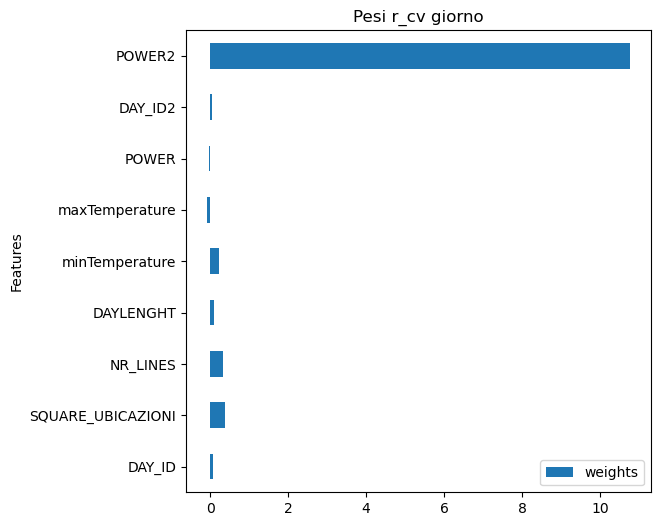

In [61]:
df_w = pd.DataFrame({'features': X_day.columns, 'weights': r_cv_day.coef_})
ax = df_w.plot.barh(y='weights', x='features', figsize=(6, 6))
ax.set_ylabel('Features')
ax.set_title('Pesi r_cv giorno')

Text(0.5, 1.0, 'Pesi r_cv notte')

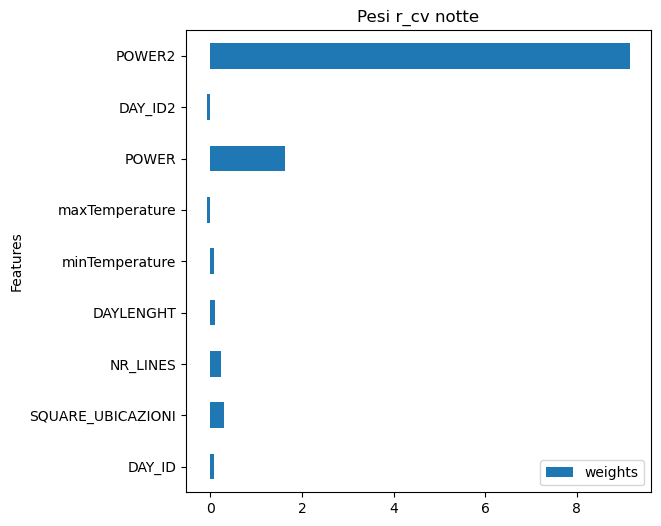

In [62]:
df_w = pd.DataFrame({'features': X_night.columns, 'weights': r_cv_night.coef_})
ax = df_w.plot.barh(y='weights', x='features', figsize=(6, 6))
ax.set_ylabel('Features')
ax.set_title('Pesi r_cv notte')

L'importanza delle features sembra avere lo stesso andamento rispetto al caso in cui si è utilizzato un solo giorno. La feature più importante rimane comunque la potenza erogata il giorno precedente. Possiamo dunque concludere che non c'è molta differenza tra utilizzare il giorno precedente e utilizzare i due giorni precedenti, perchè il modello prende in considerazione soprattutto la potenza del giorno prima.

# Dati comune di Trento

Carichiamo adesso i dati riguardanti solamente il comune di Trento

In [63]:
df_day_nov=pd.read_csv("reg/df_day_trento_nov.csv")
del df_day_nov['Unnamed: 0']
df_day_dec=pd.read_csv("reg/df_day_trento_dec.csv")
del df_day_dec['Unnamed: 0']
df_day_dec['DAY']=df_day_dec['DAY']+30
df_day_trento=pd.concat([df_day_nov, df_day_dec], ignore_index=True)

df_night_nov=pd.read_csv("reg/df_night_trento_nov.csv")
del df_night_nov['Unnamed: 0']
df_night_dec=pd.read_csv("reg/df_night_trento_dec.csv")
del df_night_dec['Unnamed: 0']
df_night_dec['DAY']=df_night_dec['DAY']+30
df_night_trento=pd.concat([df_night_nov, df_night_dec], ignore_index=True)

df_day_trento['POWER_NEXT']=np.where(df_day_trento['SQUAREID'].shift(-1)==df_day_trento['SQUAREID'], df_day_trento['POWER'].shift(-1), np.NaN)
df_day_trento.dropna(inplace=True)
df_night_trento['POWER_NEXT']=np.where(df_night_trento['SQUAREID'].shift(-1)==df_night_trento['SQUAREID'], df_night_trento['POWER'].shift(-1), np.NaN)
df_night_trento.dropna(inplace=True)

In [64]:
df_day_nov=pd.read_csv("reg/df_day_nov.csv")
del df_day_nov['Unnamed: 0']
df_day_dec=pd.read_csv("reg/df_day_dec.csv")
del df_day_dec['Unnamed: 0']
df_day_dec['DAY']=df_day_dec['DAY']+30
df_day=pd.concat([df_day_nov, df_day_dec], ignore_index=True)

df_night_nov=pd.read_csv("reg/df_night_nov.csv")
del df_night_nov['Unnamed: 0']
df_night_dec=pd.read_csv("reg/df_night_dec.csv")
del df_night_dec['Unnamed: 0']
df_night_dec['DAY']=df_night_dec['DAY']+30
df_night=pd.concat([df_night_nov, df_night_dec], ignore_index=True)

df_day['POWER_NEXT']=np.where(df_day['SQUAREID'].shift(-1)==df_day['SQUAREID'], df_day['POWER'].shift(-1), np.NaN)
df_day.dropna(inplace=True)
df_night['POWER_NEXT']=np.where(df_night['SQUAREID'].shift(-1)==df_night['SQUAREID'], df_night['POWER'].shift(-1), np.NaN)
df_night.dropna(inplace=True)

Vediamo adesso come i modelli creati in precedenza prevedono questi dati

In [65]:
X_day=df_day[['VEN','SAB','DOM','SQUARE_UBICAZIONI','NR_LINES','POWER']]

X_day=df_day_trento[['VEN','SAB','DOM','SQUARE_UBICAZIONI','NR_LINES','POWER']]

X_night=df_night[['VEN','SAB','DOM','SQUARE_UBICAZIONI','NR_LINES','POWER']]

X_night=df_night_trento[['VEN','SAB','DOM','SQUARE_UBICAZIONI','NR_LINES','POWER']]
Y_day=df_day_trento['POWER_NEXT']
Y_night=df_night_trento['POWER_NEXT']


In [66]:
score = best_model_day.score(scal.transform(X_day),Y_day)
Err = mean_squared_error(best_model_day.predict(scal.transform(X_day)),Y_day)
print(f"r^2_train {score} - Err: {Err}")
score = best_model_night.score(scal.transform(X_night),Y_night)
Err = mean_squared_error(best_model_night.predict(scal.transform(X_night)),Y_night)
print(f"r^2_train {score} - Err: {Err}")

r^2_train 0.9808127115813396 - Err: 38.98892015336584
r^2_train 0.9931893519448124 - Err: 7.253252685002826


Gli errori nel modello dei dati nella fascia oraria 9-18 sono circa 5 volte più grandi rispetto a quelli della notte, proviamo a creare un nuovo modello basato solo sui dati della zona urbana di Trento.

In [67]:
X_day=df_day_trento[['DAY','VEN','SAB','DOM','SQUARE_UBICAZIONI','NR_LINES','POWER','POWER_NEXT']]

scal_trento = StandardScaler()
X_train_day=X_day[(X_day['DAY']%2==0)]
X_valid_day=X_day[(X_day['DAY']%4==1)]
X_test_day=X_day[(X_day['DAY']%4==3)]

Y_train_day=X_train_day['POWER_NEXT']
Y_valid_day=X_valid_day['POWER_NEXT']
Y_test_day=X_test_day['POWER_NEXT']

X_day.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_train_day.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_valid_day.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
X_test_day.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)


scal_trento.fit(X_day)
X_train_day=scal_trento.transform(X_train_day)
X_valid_day=scal_trento.transform(X_valid_day)
X_test_day=scal_trento.transform(X_test_day)


C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\706981509.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_day.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\706981509.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_day.drop(['POWER_NEXT','DAY'], axis=1,inplace=True)
C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\706981509.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [68]:
r_cv_day_trento = RidgeCV(alphas= np.logspace(-4,0,num=30), cv=10)
r_cv_day_trento.fit(X_train_day, Y_train_day)

print('Modello lineare giorno:')
print_errors(r_cv_day_trento,X_train_day,Y_train_day,X_valid_day,Y_valid_day)

Modello lineare giorno:
r^2_train 0.9611136634990547 - r^2_valid 0.9688880368276649
Err_train 80.07926826689076 - Err_valid 62.83555152424494


Gli errori rimangono comunque alti,proviamo a utilizzare il logaritmo sulle potenze 

In [69]:
df_day_trento=df_day_trento[(df_day_trento['POWER']>0)&(df_day_trento['POWER_NEXT']>0)]
df_day_trento['LOG_POW']=np.log10(df_day_trento['POWER'])
df_day_trento['LOG_POW_NEXT']=np.log10(df_day_trento['POWER_NEXT'])
df_day_trento.dropna(how='all',inplace=True)
df_night_trento=df_day_trento[(df_night_trento['POWER']>0)&(df_night_trento['POWER_NEXT']>0)]
df_night_trento['LOG_POW']=np.log10(df_night_trento['POWER'])
df_night_trento['LOG_POW_NEXT']=np.log10(df_night_trento['POWER_NEXT'])
df_night_trento.dropna(how='all',inplace=True)

In [70]:
X_day=df_day_trento[['DAY','VEN','SAB','DOM','SQUARE_UBICAZIONI','NR_LINES','LOG_POW','LOG_POW_NEXT','POWER_NEXT','HIGH_POW']]
X_night=df_night_trento[['DAY','VEN','SAB','DOM','SQUARE_UBICAZIONI','NR_LINES','LOG_POW','LOG_POW_NEXT','POWER_NEXT','HIGH_POW']]


scal_trento_log = StandardScaler()
X_train_day=X_day[(X_day['DAY']%2==0)]
X_valid_day=X_day[(X_day['DAY']%4==1)]
X_test_day=X_day[(X_day['DAY']%4==3)]

X_train_night=X_night[(X_night['DAY']%2==0)]
X_valid_night=X_night[(X_night['DAY']%4==1)]
X_test_night=X_night[(X_night['DAY']%4==3)]

Y_train_day=X_train_day['LOG_POW_NEXT']
Y_valid_day=X_valid_day['LOG_POW_NEXT']
Y_test_day=X_test_day['LOG_POW_NEXT']

Y_train_night=X_train_night['LOG_POW_NEXT']
Y_valid_night=X_valid_night['LOG_POW_NEXT']
Y_test_night=X_test_night['LOG_POW_NEXT']

X_day.drop(['LOG_POW_NEXT','POWER_NEXT','DAY'], axis=1,inplace=True)
X_train_day.drop(['LOG_POW_NEXT','POWER_NEXT','DAY'], axis=1,inplace=True)
X_valid_day.drop(['LOG_POW_NEXT','POWER_NEXT','DAY'], axis=1,inplace=True)
X_test_day.drop(['LOG_POW_NEXT','POWER_NEXT','DAY'], axis=1,inplace=True)

X_night.drop(['LOG_POW_NEXT','POWER_NEXT','DAY'], axis=1,inplace=True)
X_train_night.drop(['LOG_POW_NEXT','POWER_NEXT','DAY'], axis=1,inplace=True)
X_valid_night.drop(['LOG_POW_NEXT','POWER_NEXT','DAY'], axis=1,inplace=True)
X_test_night.drop(['LOG_POW_NEXT','POWER_NEXT','DAY'], axis=1,inplace=True)

scal_trento_log.fit(X_day)
X_train_day=scal_trento_log.transform(X_train_day)
X_valid_day=scal_trento_log.transform(X_valid_day)
X_test_day=scal_trento_log.transform(X_test_day)

X_train_night=scal_trento_log.transform(X_train_night)
X_valid_night=scal_trento_log.transform(X_valid_night)
X_test_night=scal_trento_log.transform(X_test_night)






C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\3077485494.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_day.drop(['LOG_POW_NEXT','POWER_NEXT','DAY'], axis=1,inplace=True)
C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\3077485494.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_day.drop(['LOG_POW_NEXT','POWER_NEXT','DAY'], axis=1,inplace=True)
C:\Users\Federico\AppData\Local\Temp\ipykernel_13696\3077485494.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [71]:
r_cv_trento_log = RidgeCV(alphas= np.logspace(-4,0,num=30), cv=10)
r_cv_trento_log.fit(X_train_day, Y_train_day)

print('Modello lineare giorno:')
print_errors(r_cv_trento_log,X_train_day,Y_train_day,X_valid_day,Y_valid_day)

Modello lineare giorno:
r^2_train 0.9850712687459026 - r^2_valid 0.9872940682608966
Err_train 0.003131930286917306 - Err_valid 0.002696785666560081


In [72]:
X_final_day=np.concatenate([X_train_day, X_valid_day])
X_final_night=np.concatenate([X_train_night, X_valid_night])
Y_final_day=np.concatenate([Y_train_day, Y_valid_day])
Y_final_night=np.concatenate([Y_train_night, Y_valid_night])

In [73]:
r_cv_trento_log.fit(X_final_day, Y_final_day)
print('Modello dati trento fascia oraria 9-18:')
print_errors(r_cv_trento_log,X_final_day,Y_final_day,X_test_day,Y_test_day)

Modello dati trento fascia oraria 9-18:
r^2_train 0.9861463346651022 - r^2_valid 0.9846469747031238
Err_train 0.002918060419120085 - Err_valid 0.0032410193731352496


Siamo riusciti a ottenere un modello buono, otteniamo gli stessi risultati utilizzando i dati riguardanti la fascia notturna:

In [74]:
print_errors(r_cv_trento_log,X_final_night,Y_final_night,X_test_night,Y_test_night)

r^2_train 0.9861463346651022 - r^2_valid 0.9846469747031238
Err_train 0.002918060419120085 - Err_valid 0.0032410193731352496


Stampiamo alcuni grafici

In [75]:
df_day_trento['PRED']=10**r_cv_trento_log.predict(scal_trento_log.transform(X_day))

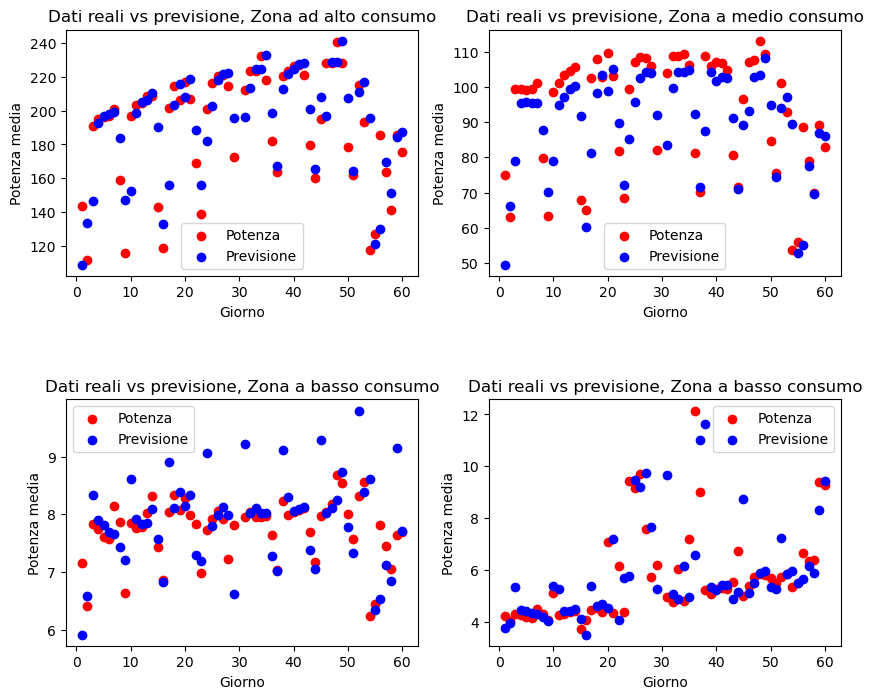

In [76]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Primo subplot
df_graph= df_day_trento[(df_day_trento["SQUAREID"] == 5201)]
axs[0, 0].scatter(df_graph['DAY'], df_graph['POWER_NEXT'], color='r', label='Potenza')
axs[0, 0].scatter(df_graph['DAY'], df_graph['PRED'], color='b', label='Previsione')
axs[0, 0].set_xlabel('Giorno')
axs[0, 0].set_ylabel('Potenza media')
axs[0, 0].set_title('Dati reali vs previsione, Zona ad alto consumo')
axs[0, 0].legend()

# Secondo subplot
df_graph= df_day_trento[(df_day_trento["SQUAREID"] == 5434)]
axs[0, 1].scatter(df_graph['DAY'], df_graph['POWER_NEXT'], color='r', label='Potenza')
axs[0, 1].scatter(df_graph['DAY'], df_graph['PRED'], color='b', label='Previsione')
axs[0, 1].set_xlabel('Giorno')
axs[0, 1].set_ylabel('Potenza media')
axs[0, 1].set_title('Dati reali vs previsione, Zona a medio consumo')
axs[0, 1].legend()
# Terzo subplot
df_graph= df_day_trento[(df_day_trento["SQUAREID"] == 5552)]
axs[1, 0].scatter(df_graph['DAY'], df_graph['POWER_NEXT'], color='r', label='Potenza')
axs[1, 0].scatter(df_graph['DAY'], df_graph['PRED'], color='b', label='Previsione')
axs[1, 0].set_xlabel('Giorno')
axs[1, 0].set_ylabel('Potenza media')
axs[1, 0].set_title('Dati reali vs previsione, Zona a basso consumo')
axs[1, 0].legend()
# Quarto subplot
df_graph= df_day_trento[(df_day_trento["SQUAREID"] == 5199)]
axs[1, 1].scatter(df_graph['DAY'], df_graph['POWER_NEXT'], color='r', label='Potenza')
axs[1, 1].scatter(df_graph['DAY'], df_graph['PRED'], color='b', label='Previsione')
axs[1, 1].set_xlabel('Giorno')
axs[1, 1].set_ylabel('Potenza media')
axs[1, 1].set_title('Dati reali vs previsione, Zona a basso consumo')
axs[1, 1].legend()

plt.subplots_adjust(hspace=0.5)

plt.show()

L'utilizzo dei dati basati sul logaritmo delle potenze ci consente di ottenere buone previsioni per tutte le zone del comune di Trento.
In conclusione, l'utilizzo dei dati basati sul logaritmo delle potenze si rivela efficace per ottenere previsioni accurate e coerenti per tutte le zone sia del comune di Trento sia per le altre zone del Trentino. Questo approccio consente di migliorare la varianza tra le zone e di ottenere risultati promettenti per la previsione del consumo energetico.

Infine salviamo tutti i modelli creati

In [77]:
from joblib import dump, load

In [79]:
models = {'Ridge_day':{'filename':'Ridge_day.pkl','value':r_cv_day},
          'Ridge_night':{'filename':'Ridge_night.pkl','value':r_cv_night},
          'Best_model_day':{'filename':'Best_model_day.pkl','value':best_model_day},
          'Best_model_night':{'filename':'Best_model_night.pkl','value':best_model_night},
          'log_model':{'filename':'log_model','value':best_model_day_log},
          'Trento_log_model':{'filename':'Trento_log_model.pkl','value':r_cv_trento_log}}
          
dump(models['Ridge_day']['value'],models['Ridge_day']['filename'])
pklfiles = [dump(**mod) for mod in models.values()]